1. **Nome(s): Jordano Furtado de Souza, Felipe Sala Carpes, Marcos Vinícius Silva**
2. **Email : jordano.souza@edu.ufes.br, felipe.carpes@edu.ufes.br, marcos.s.silva@edu.ufes.br**
3. **Matrícula(s): 2022101183, 2022102425, 2020100954**
4. **Curso(s): Engenharia de Computação**

# Projeto Final - Ciência de Dados

### Metodologia
  - Introdução
  - Definição do problema
  - Descrição do conjunto de dados
  - Metodologia
  - Resultados
  - Conclusões e discussões


## 1. Processamento da Tabela de Pedidos (`orders_dataset`)

O primeiro passo do pipeline consiste em transformar as datas brutas de logística em métricas de desempenho operacional. O objetivo é converter instantes temporais em **intervalos de tempo (Timedeltas)**, que possuem maior poder preditivo para o nosso classificador de satisfação. As métricas geradas são:
1. **Tempo de Entrega Real**: O período total que o cliente esperou pelo produto.
2. **Tempo de Delay (Atraso)**: A diferença entre a promessa de entrega e a realidade (valores positivos indicam atraso).
3. **Tempo de Despache**: Eficiência do vendedor e da logística interna até a entrega para a transportadora.

In [283]:
import pandas as pd
import numpy as np

# Configuração para visualizar todas as colunas
pd.set_option('display.max_columns', None)

In [284]:
# carregar dataset
df_orders = pd.read_csv('dataset/raw/orders_dataset.csv')

# remover pedidos que ainda não foram entregues
df_orders = df_orders[df_orders['order_status'] == 'delivered'].copy()

In [285]:
# conversão de string para datetime
cols_date = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
for col in cols_date:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [286]:
# transformação de tempo em dias
df_orders['tempo_entrega_real'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.total_seconds() / 86400
df_orders['tempo_delay'] = (df_orders['order_delivered_customer_date'] - df_orders['order_estimated_delivery_date']).dt.total_seconds() / 86400
df_orders['tempo_despache'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_approved_at']).dt.total_seconds() / 86400
# df_orders[['tempo_entrega_real', 'tempo_delay', 'tempo_despache']].head()

In [287]:
# colunas finais referente a losgistica das entrehgas
colunas_finais = [
    'order_id', 
    'customer_id', 
    'order_purchase_timestamp',  # Mantendo a referência temporal
    'tempo_entrega_real', 
    'tempo_delay', 
    'tempo_despache'
]
# salvando tabela
df_final_time = df_orders[colunas_finais].copy()

# Visualizar o resultado
df_final_time.head()

,order_id,customer_id,order_purchase_timestamp,tempo_entrega_real,tempo_delay,tempo_despache
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,8.436574,-7.107488,2.366493
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,13.782037,-5.355729,0.462882
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,9.394213,-17.245498,0.204595
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,13.208750,-12.980069,3.745833
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2.873877,-9.238171,0.893113


## 2. Processamento da Tabela de Produtos (products_dataset)

O objetivo desta etapa é extrair características físicas e de categoria que possam influenciar a expectativa do cliente. Produtos "complexos" (como eletrônicos com descrições longas) ou produtos "críticos" (grandes e pesados) tendem a ter um comportamento de avaliação diferente de itens pequenos e simples.

As métricas geradas são:
1. **Volume do Produto**: Calculado a partir das dimensões (comprimento × altura × largura).
2. **Densidade do Produto**: Relação entre peso e volume, útil para identificar produtos frágeis ou muito robustos.
3. **Nível de Detalhamento**: Comprimento da descrição e nome do produto (hipótese: descrições muito curtas podem gerar expectativas erradas).

In [288]:
# carregar dataset
df_prod = pd.read_csv('dataset/raw/products_dataset.csv')

In [289]:
# calculo volume
df_prod['product_volume_cm3'] = (
    df_prod['product_length_cm'] * df_prod['product_height_cm'] * df_prod['product_width_cm']
)

# Tratando volume 0 para evitar erro na densidade
df_prod['product_volume_cm3'] = df_prod['product_volume_cm3'].replace(0, np.nan)

# calculo densidade
df_prod['product_density'] = df_prod['product_weight_g'] / df_prod['product_volume_cm3']

# preenchimento de valores não preenchidos
cols_fix = ['product_description_lenght', 'product_name_lenght', 'product_photos_qty', 'product_density', 'product_volume_cm3']
for col in cols_fix:
    df_prod[col] = df_prod[col].fillna(0)

In [290]:
# configuração final
df_final_products = df_prod[[
    'product_id', 
    'product_volume_cm3', 
    'product_density', 
    'product_description_lenght', 
    'product_photos_qty'
]].copy()

# Visualizar o resultado
df_final_products.head(10)

,product_id,product_volume_cm3,product_density,product_description_lenght,product_photos_qty
0,1e9e8ef04dbcff4541ed26657ea517e5,2240.0,0.100446,287.0,1.0
1,3aa071139cb16b67ca9e5dea641aaa2f,10800.0,0.092593,276.0,1.0
2,96bd76ec8810374ed1b65e291975717f,2430.0,0.063374,250.0,1.0
3,cef67bcfe19066a932b7673e239eb23d,2704.0,0.137204,261.0,1.0
4,9dc1a7de274444849c219cff195d0b71,4420.0,0.141403,402.0,4.0
5,41d3672d4792049fa1779bb35283ed13,2090.0,0.095694,745.0,1.0
6,732bd381ad09e530fe0a5f457d81becb,73920.0,0.248241,1272.0,4.0
7,2548af3e6e77a690cf3eb6368e9ab61e,12800.0,0.070312,184.0,2.0
8,37cc742be07708b53a98702e77a21a02,5967.0,0.067035,163.0,1.0
9,8c92109888e8cdf9d66dc7e463025574,2040.0,0.294118,1156.0,1.0


## 3. Processamento da Tabela de Itens (`order_items_dataset`)

Nesta etapa, analisamos a "dor financeira" do cliente. A percepção de valor e o custo do frete são fatores psicológicos determinantes na tolerância a falhas logísticas. 

Também foi preciso realizar um merge antecipado entre os dataset products_dataset e order_items_dataset, para não perder informação entre as tabelas

Para isso, realizamos uma **agregação por pedido**, calculando o valor total dos itens e do frete. Introduzimos também uma métrica de **proporcionalidade**, que indica o quão "caro" o frete pareceu para o consumidor em relação ao produto adquirido.

As métricas geradas são:
1. **Valor Total do Pedido**: Soma dos preços de todos os itens do pedido.
2. **Valor Total do Frete**: Custos logísticos totais acumulados.
3. **Quantidade de Itens**: Número total de produtos no carrinho (indicador de complexidade logística).
4. **Ratio Frete/Produto**: Razão entre frete e valor dos itens (Métrica de percepção de custo-benefício).
5. **Ticket Médio por Item**: Pedidos com itens caros tendem a gerar maior ansiedade no cliente

In [291]:
# carregar dataset
df_items = pd.read_csv('dataset/raw/order_items_dataset.csv')

# unir itens com a tabelas de produtos
df_items_enriquecido = df_items.merge(df_final_products, on='product_id', how='left')

In [292]:
# agrupamento por pedido
df_final_price = df_items_enriquecido.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
    'order_item_id': 'count',
    'product_volume_cm3': 'mean',
    'product_density': 'mean',
    'product_description_lenght': 'mean',
}).reset_index()

In [293]:
# ajustando nome colunas
df_final_price.columns = [
    'order_id', 'vl_total_pedido', 'vl_frete_total', 'qtd_itens', 
    'avg_volume', 'avg_density', 'avg_description_len'
]
# nova feature de proporcionalidade, entre o valor do pedido com o frete 
df_final_price['ratio_frete_produto'] = df_final_price['vl_frete_total'] / df_final_price['vl_total_pedido']

# nova feature de preço médio do produto, identifica se foi uma compra de produtos caros ou muitos produtos
df_final_price['ticket_medio_item'] = df_final_price['vl_total_pedido'] / df_final_price['qtd_itens']

# Visualizar o resultado
df_final_price.head(10)

,order_id,vl_total_pedido,vl_frete_total,qtd_itens,avg_volume,avg_density,avg_description_len,ratio_frete_produto,ticket_medio_item
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,3528.0,0.184240,598.0,0.225637,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1,60000.0,0.500000,239.0,0.083076,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,14157.0,0.215441,695.0,0.089799,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1,2400.0,0.083333,480.0,0.984604,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,42000.0,0.089286,409.0,0.090745,199.90
5,00048cc3ae777c65dbb7d2a0634bc1ea,21.90,12.69,1,2880.0,0.156250,558.0,0.579452,21.90
6,00054e8431b9d7675808bcb819fb4a32,19.90,11.85,1,2700.0,0.074074,815.0,0.595477,19.90
7,000576fe39319847cbb9d288c5617fa6,810.00,70.75,1,118125.0,0.116868,1310.0,0.087346,810.00
8,0005a1a1728c9d785b8e2b08b904576c,145.95,11.65,1,5760.0,0.347222,493.0,0.079822,145.95
9,0005f50442cb953dcd1d21e1fb923495,53.99,11.40,1,1827.0,0.465244,1192.0,0.211150,53.99


## 4. Processamento da Tabela de Clientes (customers_dataset)

O objetivo desta etapa é extrair a localização do consumidor. 

In [294]:
# carregar o dataset
df_customers = pd.read_csv('dataset/raw/customers_dataset.csv')

cols_customers = [
    'customer_id',
    'customer_city',
    'customer_state'
]

In [295]:
df_customers = df_customers[cols_customers].copy()

# padronizar a escrita
df_customers['customer_city'] = df_customers['customer_city'].str.upper()
df_customers['customer_state'] = df_customers['customer_state'].str.upper()

# salvando tabela, só as colunas importantes
df_final_costumers = df_customers.copy()

# Visualizar o resultado
df_final_costumers.head()

,customer_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,FRANCA,SP
1,18955e83d337fd6b2def6b18a428ac77,SAO BERNARDO DO CAMPO,SP
2,4e7b3e00288586ebd08712fdd0374a03,SAO PAULO,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,MOGI DAS CRUZES,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,CAMPINAS,SP


## 5. Processamento da Tabela de Avaliações (order_reviews_dataset)

O objetivo do nosso trabalho.

- Classe 0 (Insatisfeito): Notas 1, 2 e 3.
- Classe 1 (Satisfeito): Notas 4 e 5.

In [296]:
# carregar o dataset
df_reviews = pd.read_csv('dataset/raw/order_reviews_dataset.csv')

In [297]:
def binarizar_nota(score):
    if score >= 4:
        return 1 # Satisfeito
    else:
        return 0 # Insatisfeito

In [298]:
df_reviews['target_label'] = df_reviews['review_score'].apply(binarizar_nota)
df_final_reviews = df_reviews[['order_id', 'review_score', 'target_label']].copy()
df_final_reviews.head()

,order_id,review_score,target_label
0,73fc7af87114b39712e6da79b0a377eb,4,1
1,a548910a1c6147796b98fdf73dbeba33,5,1
2,f9e4b658b201a9f2ecdecbb34bed034b,5,1
3,658677c97b385a9be170737859d3511b,5,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,1


## 6. Construção Tabela Final 

In [299]:
# Iniciando o merge a partir dos reviews (base do target)
df_master = df_final_reviews.copy()

# Join com Logística
df_master = df_master.merge(df_final_time, on='order_id', how='left')

# Join com Preços e Produtos 
df_master = df_master.merge(df_final_price, on='order_id', how='left')

# Join com Clientes 
df_master = df_master.merge(df_final_costumers, on='customer_id', how='left')

In [300]:
# Limpeza final de registros incompletos
df_master = df_master.dropna()

# Adicionando Flag de Atraso Binário
df_master['is_late'] = (df_master['tempo_delay'] > 0).astype(int)

print(f"Dataset Final: {df_master.shape}")


Dataset Final: (96992, 19)


In [301]:
# Dicionário de tradução e padronização
colunas_portugues = {
    'order_id': 'id_pedido',
    'customer_id': 'id_cliente',
    'review_score': 'nota_avaliacao',
    'target_label': 'alvo_insatisfacao',
    'order_purchase_timestamp': 'data_compra',
    'tempo_entrega_real': 'tempo_entrega_dias',
    'tempo_delay': 'atraso_estimado_dias',
    'tempo_despache': 'tempo_postagem_vendedor_dias',
    'vl_total_pedido': 'valor_total_pedido',
    'vl_frete_total': 'valor_frete_total',
    'qtd_itens': 'quantidade_itens',
    'avg_volume': 'volume_medio_cm3',
    'avg_density': 'densidade_media_gcm3',
    'avg_desc_len': 'tamanho_medio_descricao',
    'ratio_frete_produto': 'proporcao_frete_produto',
    'ticket_medio_item': 'valor_medio_por_item',
    'customer_zip_code_prefix': 'cep_prefixo_cliente',
    'customer_city': 'cidade_cliente',
    'customer_state': 'uf_cliente',
    'is_late': 'indicador_atraso'
}

# Aplicando a renomeação
df_master = df_master.rename(columns=colunas_portugues)

df_master.to_csv('dataset/processed/tabela_combinada_versao_1.csv', index=False)

# Verificando o resultado
print(df_master.columns.tolist())

['id_pedido', 'nota_avaliacao', 'alvo_insatisfacao', 'id_cliente', 'data_compra', 'tempo_entrega_dias', 'atraso_estimado_dias', 'tempo_postagem_vendedor_dias', 'valor_total_pedido', 'valor_frete_total', 'quantidade_itens', 'volume_medio_cm3', 'densidade_media_gcm3', 'avg_description_len', 'proporcao_frete_produto', 'valor_medio_por_item', 'cidade_cliente', 'uf_cliente', 'indicador_atraso']


###  Dicionário de Dados do Dataset Consolidado (`df_master`)

Esta tabela serve como referência técnica para entender cada variável (feature) que o classificador utilizará para prever a satisfação do cliente.

| Coluna | Descrição |
| :--- | :--- |
| **id_pedido** | Identificador único do pedido. |
| **id_cliente** | Identificador do cliente associado ao pedido. |
| **nota_avaliacao** | Pontuação de satisfação dada pelo usuário (1 a 5). |
| **alvo_insatisfacao** | **Target (Variável Alvo)**: 1 para Satisfeito (notas 4 e 5) e 0 para Insatisfeito (notas 1, 2 e 3). |
| **data_compra** | Carimbo de data e hora de quando o pedido foi realizado. |
| **tempo_entrega_dias** | Tempo total (em dias) desde a compra até a entrega efetiva ao cliente. |
| **atraso_estimado_dias** | Diferença entre a entrega real e a estimativa inicial (valores positivos indicam atraso). |
| **tempo_postagem_vendedor_dias** | Tempo que o vendedor levou para despachar o produto após a aprovação do pedido. |
| **valor_total_pedido** | Valor total da soma dos preços de todos os itens do pedido. |
| **valor_frete_total** | Valor total acumulado do frete para o pedido. |
| **quantidade_itens** | Número total de itens inclusos no mesmo pedido. |
| **volume_medio_cm3** | Média do volume físico (C x A x L) dos produtos que compõem o pedido. |
| **densidade_media_gcm3** | Média da densidade (peso/volume) dos produtos comprados. |
| **tamanho_medio_descricao** | Média da quantidade de caracteres na descrição técnica dos produtos. |
| **proporcao_frete_produto** | Razão entre o custo do frete e o valor total do produto (sensibilidade ao preço). |
| **valor_medio_por_item** | Valor médio (ticket médio) de cada item individual no pedido. |
| **cidade_cliente** | Nome da cidade de destino da entrega. |
| **uf_cliente** | Estado (Unidade da Federação) do comprador. |
| **indicador_atraso** | Flag binária: 1 se houve atraso em relação à estimativa, 0 caso contrário. |

In [302]:
# Testes básicos antes de iniciar o processo do classificador

# Contagem absoluta
print("Distribuição das Classes:")
print(df_master['alvo_insatisfacao'].value_counts())

# Contagem percentual
print("\nPercentual das Classes:")
print(df_master['alvo_insatisfacao'].value_counts(normalize=True) * 100)

cols_analise = ['tempo_entrega_dias', 'atraso_estimado_dias', 'valor_total_pedido', 'proporcao_frete_produto']
display(df_master[cols_analise].describe())

# Calculando a correlação apenas das colunas numéricas com o alvo
correlacoes = df_master.corr(numeric_only=True)['alvo_insatisfacao'].sort_values(ascending=False)

print("Correlação das variáveis com a Satisfação do Cliente:")
print(correlacoes)

Distribuição das Classes:
alvo_insatisfacao
1    76170
0    20822
Name: count, dtype: int64

Percentual das Classes:
alvo_insatisfacao
1    78.53225
0    21.46775
Name: proportion, dtype: float64


,tempo_entrega_dias,atraso_estimado_dias,valor_total_pedido,proporcao_frete_produto
count,96992.000000,96992.000000,96992.000000,96992.000000
mean,12.564054,-11.181226,136.897884,0.308562
std,9.542185,10.184474,208.714371,0.311539
min,0.533414,-146.016123,0.850000,0.000000
25%,6.771056,-16.244314,45.900000,0.132117
50%,10.224144,-11.948536,86.000000,0.224430
75%,15.732433,-6.391869,149.900000,0.380845
max,209.628611,188.975081,13440.000000,21.447059


Correlação das variáveis com a Satisfação do Cliente:
alvo_insatisfacao               1.000000
nota_avaliacao                  0.896701
avg_description_len             0.016619
densidade_media_gcm3            0.001259
valor_medio_por_item           -0.000372
proporcao_frete_produto        -0.022653
volume_medio_cm3               -0.023594
valor_total_pedido             -0.027046
valor_frete_total              -0.080693
quantidade_itens               -0.111665
tempo_postagem_vendedor_dias   -0.137569
atraso_estimado_dias           -0.235312
tempo_entrega_dias             -0.293894
indicador_atraso               -0.321770
Name: alvo_insatisfacao, dtype: float64


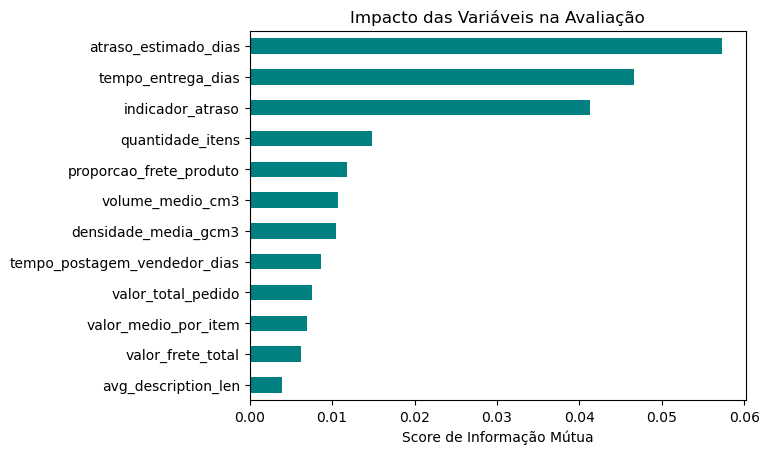

In [303]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

#removendo colunas que não são relevantes
cols_to_drop = ['uf_cliente', 'cidade_cliente', 'id_pedido', 'id_cliente', 'data_compra']
X = df_master.drop(columns= cols_to_drop + ['nota_avaliacao', 'alvo_insatisfacao'])
y = df_master['alvo_insatisfacao']

# 3. Calcular Informação Mútua
importances = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 4. Visualização
feature_importances = pd.Series(importances, index=X.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', color='teal')
plt.title('Impacto das Variáveis na Avaliação')
plt.xlabel('Score de Informação Mútua')
plt.show()



In [304]:
from sklearn.feature_selection import SelectKBest

#verificando as K caricteristicas mais importantes 
ms = SelectKBest(score_func = mutual_info_classif, k = 7)
ms.fit(X, y);

ms.set_output(transform = 'pandas')
ms.transform(X)

,tempo_entrega_dias,atraso_estimado_dias,valor_frete_total,quantidade_itens,volume_medio_cm3,proporcao_frete_produto,indicador_atraso
0,6.133241,-15.220359,27.26,2.0,31500.0,0.073676,0
1,9.452789,-4.029630,8.30,1.0,3724.0,0.104023,0
2,13.314190,-20.271667,45.12,1.0,8000.0,0.302819,0
3,10.644005,-19.619039,42.85,1.0,8000.0,0.238069,0
4,18.232315,-8.310012,134.25,1.0,183750.0,0.111968,0
...,...,...,...,...,...,...,...
99995,4.815012,-11.278472,9.77,1.0,11799.0,0.048852,0
99996,3.327650,-15.261019,15.59,1.0,42920.0,0.072186,0
99997,7.840544,-15.459826,15.46,1.0,1760.0,0.303435,0
99998,4.138970,-14.080208,7.78,1.0,4500.0,0.778000,0
